## **MemoTag - AI/ML Task - Voice-Based Cognitive Decline Pattern Detection**
by Rishi Gupta
### **Introduction**
This project deals with building a basic proof-of-concept pipeline that uses raw voice data samples to detect
cognitive stress or decline indicators. We use techniques like audio processing, natural language processing along with suitable feature extraction.

In [1]:
# Install and load modules
!pip install datasets pandas numpy matplotlib SpeechRecognition librosa pydub

from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import speech_recognition as sr
import os
import glob
import librosa
from pydub import AudioSegment
from pydub.silence import detect_silence

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


For this task we are considering a audio dataset, which is a collection on 10 audio samples. We can perform deep audio analysis, along with transcribing to make suitable classifications.

The dataset consists of audio files which have already been classified into 'dementia' and 'control'. This will be useful to train our model.

In [2]:
# Transcribe audio files
AUDIO_FOLDER = "audio_data"

def transcribe_audio_folder(folder_path):
    recognizer = sr.Recognizer()
    
    audio_extensions = ['.wav', '.mp3', '.flac', '.aiff', '.aif', '.m4a']
    
    # Find all audio files in the folder and subfolders
    audio_files = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in audio_extensions):
                full_path = os.path.join(root, file)
                rel_path = os.path.relpath(root, folder_path)
                subfolder = "root" if rel_path == "." else rel_path
                audio_files.append((full_path, file, subfolder))
    
    # Transcribe all audio files and create a list of results
    results = []
    for full_path, filename, subfolder in audio_files:
        print(f"Processing: {filename} from {subfolder}")
        
        try:
            with sr.AudioFile(full_path) as source:
                audio_data = recognizer.record(source)
                transcript = recognizer.recognize_google(audio_data)
                
                results.append({
                    "filename": filename,
                    "transcript": transcript,
                    "output": subfolder
                })
            
        except Exception as e:
            results.append({
                    "filename": filename,
                    "transcript": transcript,
                    "output": subfolder
            })
    
    df = pd.DataFrame(results)
    return df

# Create and display the dataframe with all the transcipts
transcription_df = transcribe_audio_folder(AUDIO_FOLDER)
transcription_df.head(10)

Processing: Angela Lansbury_3.wav from control
Processing: AngeloBadalamenti_3.wav from control
Processing: JamesBrolin_3.wav from control
Processing: JerryBruckheimer_2.wav from control
Processing: MartinLandau_3.wav from control
Processing: antonyflew_5_1.wav from dementia
Processing: BenBradlee_15.wav from dementia
Processing: JackWebster_5.wav from dementia
Processing: patpariseau_10_2.wav from dementia
Processing: PaulinePhillips_10.wav from dementia


,filename,transcript,output
0,Angela Lansbury_3.wav,I only really come alive in as an interesting ...,control
1,AngeloBadalamenti_3.wav,8 years old movies and I didn't come home from...,control
2,JamesBrolin_3.wav,South Indian he came down to stay with me for ...,control
3,JerryBruckheimer_2.wav,which is what I like to do how to get me to th...,control
4,MartinLandau_3.wav,what you talking about I said I want to go int...,control
5,antonyflew_5_1.wav,yes yes I don't see why there is any reason fo...,dementia
6,BenBradlee_15.wav,and we were just as far as Delhi people you kn...,dementia
7,JackWebster_5.wav,I don't know the most basic knowledge YouTube ...,dementia
8,patpariseau_10_2.wav,me some people you know there are some people ...,dementia
9,PaulinePhillips_10.wav,San Francisco 1956 by twin sister started 3 mo...,dementia


We have the necessary transcripts for the audio files, neatly catergorized with the existing labels. Now, we can focus on the deep audio analysis.

Let's start off by looking for pauses. Abrupt and long pauses are key signs of cognitive impairment. We will be looking for number of pauses, the rate of pauses and average pause times to make our assumptions.

In [4]:
def analyze_pauses(audio_file, min_silence_len=400, silence_threshold=-45):
    audio = AudioSegment.from_file(audio_file)
    
    silent_segments = detect_silence(audio, min_silence_len, silence_threshold)
    
    # Convert to seconds
    silent_segments = [(start/1000, stop/1000) for start, stop in silent_segments]
    
    # Calculate statistics
    pause_durations = [stop - start for start, stop in silent_segments]
    total_pauses = len(pause_durations)
    audio_duration = len(audio) / 1000.0
    
    # Pause rate (pauses per second)
    pause_rate = total_pauses / audio_duration if audio_duration > 0 else 0
    
    # Average pause duration
    avg_pause_duration = float(np.mean(pause_durations) if pause_durations else 0)
    
    # Extract just the filename from the full path
    filename = os.path.basename(audio_file)
    
    return {
        'filename': filename,
        'pause_rate': pause_rate,
        'avg_pause_duration': avg_pause_duration,
    }

# Analyze all audio files and create a list of results
pause_analysis_results = []
for root, _, files in os.walk("audio_data"):
    for file in files:
        if file.lower().endswith(('.wav', '.mp3', '.flac', '.ogg')):
            full_path = os.path.join(root, file)
            pause_analysis_results.append(analyze_pauses(full_path))

# Create dataframe and merge with exsisting dataframe
pause_analysis_df = pd.DataFrame(pause_analysis_results)
merged_df = pd.merge(transcription_df, pause_analysis_df, on='filename', how='left')

merged_df.head(10)

,filename,transcript,output,pause_rate,avg_pause_duration
0,Angela Lansbury_3.wav,I only really come alive in as an interesting ...,control,0.354167,0.697235
1,AngeloBadalamenti_3.wav,8 years old movies and I didn't come home from...,control,0.222222,0.714200
2,JamesBrolin_3.wav,South Indian he came down to stay with me for ...,control,0.200000,0.656000
3,JerryBruckheimer_2.wav,which is what I like to do how to get me to th...,control,0.217391,0.488400
4,MartinLandau_3.wav,what you talking about I said I want to go int...,control,0.211111,0.802526
5,antonyflew_5_1.wav,yes yes I don't see why there is any reason fo...,dementia,0.123288,0.726111
6,BenBradlee_15.wav,and we were just as far as Delhi people you kn...,dementia,0.199973,0.768583
7,JackWebster_5.wav,I don't know the most basic knowledge YouTube ...,dementia,0.199980,0.880250
8,patpariseau_10_2.wav,me some people you know there are some people ...,dementia,0.323529,0.683000
9,PaulinePhillips_10.wav,San Francisco 1956 by twin sister started 3 mo...,dementia,0.366663,0.678303


The pause times vary, and by theory, we can typically determine the speech type based on the range of pause durations
- Healthy speech: 400–600 ms
- MCI: 600–800 ms
- Severe impairment: ≥ 800 ms

We now look for hesitation marks. The use of filler words like "um", "uh", "like" give us a sense of hesitation in the speech. Excessive use of these words can be a sign of impairment. We will again consider the rate of occurrance of these words as the lenghts of the audio files differ.

In [13]:
import re
def detect_hesitations(transcript):
    # Define hesitation markers
    hesitation_markers = ['uh', 'um', 'er', 'ah', 'like', 'you know', 'hmm']
    
    # Count total hesitations
    total_hesitations = 0
    for marker in hesitation_markers:
        pattern = r'\b' + re.escape(marker) + r'\b'
        total_hesitations += len(re.findall(pattern, transcript.lower()))
    
    words = len(transcript.split())
    hesitation_rate = total_hesitations / words if words > 0 else 0
    
    return {
        'hesitation_rate': hesitation_rate
    }
    
# Analyze all transcripts in the dataframe
hesitation_analysis_results = []
for index, row in merged_df.iterrows():
    filename = row['filename']
    transcript = row['transcript']
    
    hesitation_data = detect_hesitations(transcript)
    
    # Add filename to the results
    hesitation_data['filename'] = filename
    
    # Append to results list
    hesitation_analysis_results.append(hesitation_data)

# Create dataframe and merge with exsisting dataframe
hesitation_analysis_df = pd.DataFrame(hesitation_analysis_results)

merged2_df = pd.merge(merged_df, hesitation_analysis_df, on='filename', how='left')
merged2_df.head(10)

,filename,transcript,output,pause_rate,avg_pause_duration,hesitation_rate
0,Angela Lansbury_3.wav,I only really come alive in as an interesting ...,control,0.354167,0.697235,0.000000
1,AngeloBadalamenti_3.wav,8 years old movies and I didn't come home from...,control,0.222222,0.714200,0.000000
2,JamesBrolin_3.wav,South Indian he came down to stay with me for ...,control,0.200000,0.656000,0.048780
3,JerryBruckheimer_2.wav,which is what I like to do how to get me to th...,control,0.217391,0.488400,0.030303
4,MartinLandau_3.wav,what you talking about I said I want to go int...,control,0.211111,0.802526,0.000000
5,antonyflew_5_1.wav,yes yes I don't see why there is any reason fo...,dementia,0.123288,0.726111,0.000000
6,BenBradlee_15.wav,and we were just as far as Delhi people you kn...,dementia,0.199973,0.768583,0.044444
7,JackWebster_5.wav,I don't know the most basic knowledge YouTube ...,dementia,0.199980,0.880250,0.000000
8,patpariseau_10_2.wav,me some people you know there are some people ...,dementia,0.323529,0.683000,0.014925
9,PaulinePhillips_10.wav,San Francisco 1956 by twin sister started 3 mo...,dementia,0.366663,0.678303,0.000000


We can analyse that the hesitation metrics are not as clean as we expected. This can be because the hesitation words are not easily picked up by the transcription models, and it is not easy to properly determine them.

Now we move on to some more audio analysis, particularly speech rate and pitch variability.

In [14]:
def analyze_speech_acoustics(audio_file, sr=None):
    # Load the audio file
    y, sr = librosa.load(audio_file, sr=sr)
    
    # Extract pitch (F0) using librosa
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), 
                                               fmax=librosa.note_to_hz('C7'), sr=sr)
    
    # Remove NaN values from pitch
    f0_cleaned = f0[~np.isnan(f0)]
    
    # Calculate pitch statistics
    pitch_mean = np.mean(f0_cleaned) if len(f0_cleaned) > 0 else 0
    pitch_std = np.std(f0_cleaned) if len(f0_cleaned) > 0 else 0
    pitch_range = np.ptp(f0_cleaned) if len(f0_cleaned) > 0 else 0
    
    # Estimate speech rate (syllables per second)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    speech_rate = tempo / 60
    
    return {
        'pitch_mean': pitch_mean,
        'pitch_std': pitch_std,
        'pitch_variability': pitch_std / pitch_mean if pitch_mean > 0 else 0,
        'pitch_range': pitch_range,
        'speech_rate': speech_rate,
    }

def analyze_audio_folder(folder_path):
    audio_extensions = ['.wav', '.mp3', '.flac', '.aiff', '.aif', '.m4a']
    
    # Find all audio files in the folder and subfolders
    audio_files = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in audio_extensions):
                full_path = os.path.join(root, file)
                rel_path = os.path.relpath(root, folder_path)
                subfolder = "root" if rel_path == "." else rel_path
                audio_files.append((full_path, file, subfolder))
    
    # Analyze all audio files and create a list of results
    results = []
    for full_path, filename, subfolder in audio_files:
        print(f"Analyzing acoustics: {filename} from {subfolder}")
        
        try:
            # Analyze speech acoustics
            acoustics_data = analyze_speech_acoustics(full_path)
            
            # Add filename and subfolder to the results
            acoustics_data['filename'] = filename
            acoustics_data['output'] = subfolder
            
            # Append to results list
            results.append(acoustics_data)
            
        except Exception as e:
            print(f"Error analyzing {filename}: {str(e)}")
            # Add a row with the filename but NaN values for metrics
            results.append({
                'filename': filename,
                'output': subfolder,
                'pitch_mean': 0,
                'pitch_std': 0,
                'pitch_variability': 0,
                'pitch_range': 0,
                'speech_rate': 0
            })
    
    # Create dataframe with all the acoustic analysis results
    acoustics_df = pd.DataFrame(results)
    return acoustics_df

# Create and analyze the acoustic features
acoustics_df = analyze_audio_folder(AUDIO_FOLDER)

# Merge with existing dataframe
merged3_df = pd.merge(merged2_df, acoustics_df, on=['filename', 'output'], how='left')
merged3_df.head(10)

Analyzing acoustics: Angela Lansbury_3.wav from control
Analyzing acoustics: AngeloBadalamenti_3.wav from control
Analyzing acoustics: JamesBrolin_3.wav from control
Analyzing acoustics: JerryBruckheimer_2.wav from control
Analyzing acoustics: MartinLandau_3.wav from control
Analyzing acoustics: antonyflew_5_1.wav from dementia
Analyzing acoustics: BenBradlee_15.wav from dementia
Analyzing acoustics: JackWebster_5.wav from dementia
Analyzing acoustics: patpariseau_10_2.wav from dementia
Analyzing acoustics: PaulinePhillips_10.wav from dementia


,filename,transcript,output,pause_rate,avg_pause_duration,hesitation_rate,pitch_mean,pitch_std,pitch_variability,pitch_range,speech_rate
0,Angela Lansbury_3.wav,I only really come alive in as an interesting ...,control,0.354167,0.697235,0.000000,167.671511,29.498016,0.175927,209.299494,[2.1008003048780486]
1,AngeloBadalamenti_3.wav,8 years old movies and I didn't come home from...,control,0.222222,0.714200,0.000000,129.425192,31.997723,0.247229,239.996722,[2.2085336538461537]
2,JamesBrolin_3.wav,South Indian he came down to stay with me for ...,control,0.200000,0.656000,0.048780,118.859896,28.293151,0.238038,139.958722,[2.0030886627906974]
3,JerryBruckheimer_2.wav,which is what I like to do how to get me to th...,control,0.217391,0.488400,0.030303,99.607840,24.991489,0.250899,107.202110,[1.9575639204545456]
4,MartinLandau_3.wav,what you talking about I said I want to go int...,control,0.211111,0.802526,0.000000,97.222530,19.355119,0.199081,150.814140,[1.872452445652174]
5,antonyflew_5_1.wav,yes yes I don't see why there is any reason fo...,dementia,0.123288,0.726111,0.000000,152.743916,44.460227,0.291077,208.592526,[1.872452445652174]
6,BenBradlee_15.wav,and we were just as far as Delhi people you kn...,dementia,0.199973,0.768583,0.044444,113.936921,34.517763,0.302955,205.445380,[2.1008003048780486]
7,JackWebster_5.wav,I don't know the most basic knowledge YouTube ...,dementia,0.199980,0.880250,0.000000,163.544210,39.274952,0.240149,233.391546,[2.1008003048780486]
8,patpariseau_10_2.wav,me some people you know there are some people ...,dementia,0.323529,0.683000,0.014925,143.057580,40.918277,0.286027,219.898311,[1.8326130319148934]
9,PaulinePhillips_10.wav,San Francisco 1956 by twin sister started 3 mo...,dementia,0.366663,0.678303,0.000000,163.223722,44.644394,0.273517,291.984663,[1.872452445652174]


Now that we have our final dataset, we fill perform some cleaning and prepare the final dataset to conduct analysis and build and train our ML model on.

In [27]:
# Move output column to the end
col_to_move = 'output'
merged3_df = merged3_df[[col for col in merged3_df.columns if col != col_to_move] + [col_to_move]]

# Fix the speech_rate column - handle square brackets and convert to float
def extract_float_from_brackets(value):
    try:
        # Remove brackets and convert to float
        stripped = str(value).strip('[]')
        return float(stripped)
    except (ValueError, TypeError):
        print(f"Conversion failed for value: '{value}'")
        return np.nan

# Apply the conversion function
merged3_df['speech_rate'] = merged3_df['speech_rate'].apply(extract_float_from_brackets)

print(merged3_df.head(10))

                  filename                                         transcript  \
0    Angela Lansbury_3.wav  I only really come alive in as an interesting ...   
1  AngeloBadalamenti_3.wav  8 years old movies and I didn't come home from...   
2        JamesBrolin_3.wav  South Indian he came down to stay with me for ...   
3   JerryBruckheimer_2.wav  which is what I like to do how to get me to th...   
4       MartinLandau_3.wav  what you talking about I said I want to go int...   
5       antonyflew_5_1.wav  yes yes I don't see why there is any reason fo...   
6        BenBradlee_15.wav  and we were just as far as Delhi people you kn...   
7        JackWebster_5.wav  I don't know the most basic knowledge YouTube ...   
8     patpariseau_10_2.wav  me some people you know there are some people ...   
9   PaulinePhillips_10.wav  San Francisco 1956 by twin sister started 3 mo...   

   pause_rate  avg_pause_duration  hesitation_rate  pitch_mean  pitch_std  \
0    0.354167            0.6972

We now focus on analysing the data. Plotting the feature distributions by class and doing a correlation analysis can be a good starting point

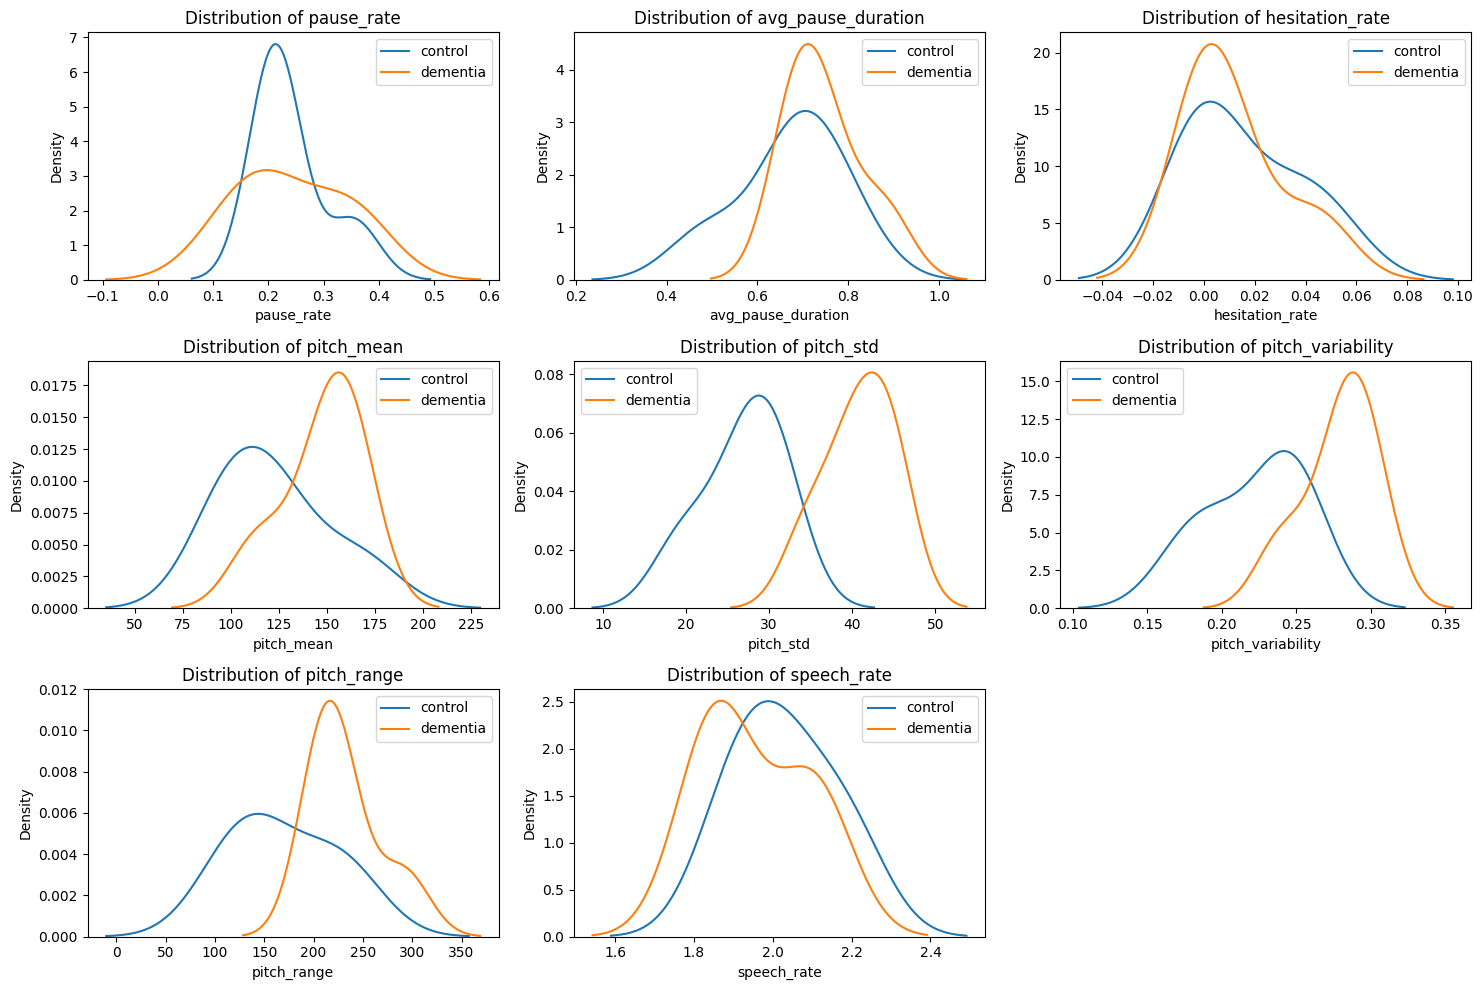

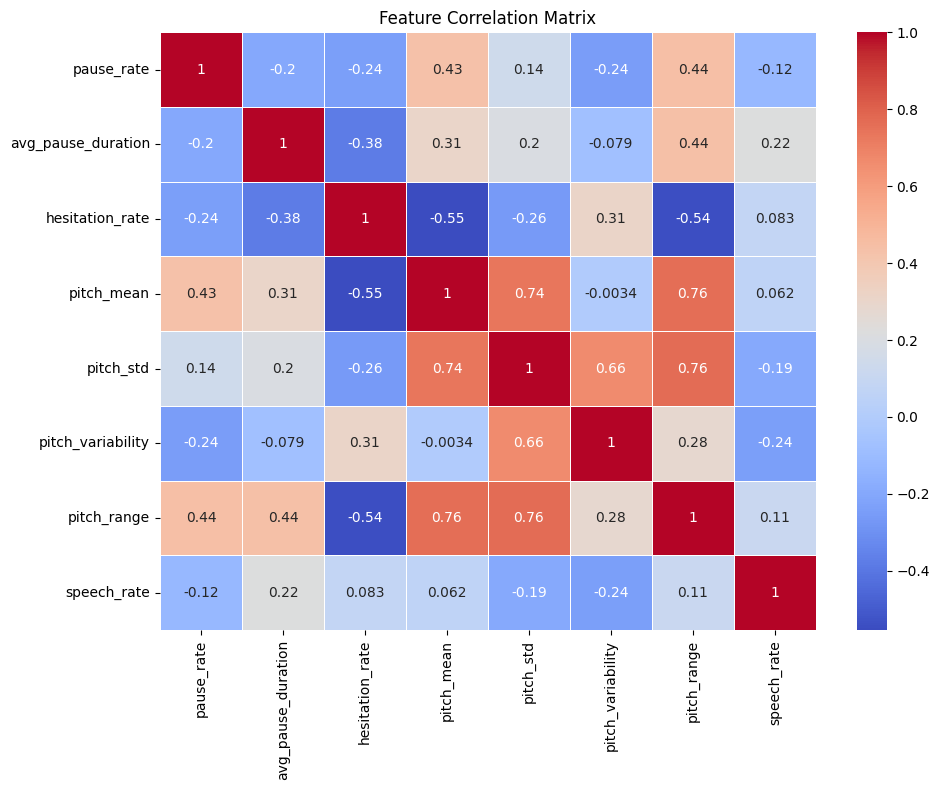

In [29]:
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load the data
data = merged3_df

# Create feature matrix X and target vector y
X = data[['pause_rate', 'avg_pause_duration', 'hesitation_rate', 
          'pitch_mean', 'pitch_std', 'pitch_variability', 
          'pitch_range', 'speech_rate']]
y = data['output']


# Plot feature distributions by class
plt.figure(figsize=(15, 10))
for i, feature in enumerate(X.columns):
    plt.subplot(3, 3, i+1)
    for target_class in y.unique():
        sns.kdeplot(X[feature][y == target_class], label=target_class)
    plt.title(f'Distribution of {feature}')
    plt.legend()
plt.tight_layout()
plt.savefig('feature_distributions.png')

# Feature correlation analysis
plt.figure(figsize=(10, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')

Individuals in the 'dementia' group tend to exhibit:
- Longer average pause durations, and higher hesitation rates.
- Higher mean pitch, greater pitch standard deviation, variability, and range.
- Lower speech rates compared to the control group.

Some key observations from the correlation analysis are:

- Strong positive correlations exist between pitch-related features, specifically `pitch_mean`, `pitch_std`, and `pitch_range` (correlations up to 0.76).
- Moderate positive correlations are seen between pause metrics (`pause_rate`, `avg_pause_duration`) and `pitch_range`.
- Strong negative correlations are observed between `hesitation_rate` and both `pitch_mean` (-0.55) and `pitch_range` (-0.54).
- `speech_rate` shows generally weak correlations with most other features.

Let's move on to building and training the model. We will build a Random Forest model to classify the data, evaluate its performance, and fine-tune it using hyperparameter optimization techniques.

In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print("\nRandom Forest Model Results:")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=3, scoring='accuracy')
print(f"\nCross-validation accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("\nBest parameters from GridSearchCV:")
print(grid_search.best_params_)

# Train the model with best parameters
best_rf_model = RandomForestClassifier(
    **grid_search.best_params_,
    random_state=42
)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate the improved model
best_y_pred = best_rf_model.predict(X_test_scaled)
print("\nOptimized Random Forest Model Results:")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, best_y_pred))
print("\nClassification Report:")
print(classification_report(y_test, best_y_pred))


Random Forest Model Results:

Confusion Matrix:
[[2 0]
 [0 1]]

Classification Report:
              precision    recall  f1-score   support

     control       1.00      1.00      1.00         2
    dementia       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3


Cross-validation accuracy: 0.5556 (±0.0786)

Feature Importances:
              Feature  Importance
4           pitch_std    0.234056
5   pitch_variability    0.215179
1  avg_pause_duration    0.141213
0          pause_rate    0.137798
3          pitch_mean    0.105839
7         speech_rate    0.068552
6         pitch_range    0.067971
2     hesitation_rate    0.029393

Best parameters from GridSearchCV:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Optimized Random Forest Model Results:

Confusion Matrix:
[[2 0]
 [0 1]]

Classificatio

The model demonstrates perfect classification (1.00 accuracy, precision, recall, F1-score) on the evaluated test set, correctly identifying all 2 'control' and 1 'dementia' samples. This perfect performance is maintained even after optimization using GridSearchCV.

However, the CV accuracy is significantly lower at 0.5556, with notable variability (±0.0786). This anomaly suggests the model may be overfitting to the specific small test set shown (only 3 samples) and does not generalize well to unseen data. Another reason could be the smaller training size.

### **Report**
 - Feature importance analysis reveals that pitch_std and pitch_variability are the most influential predictors, followed by pause-related features, and hesitation_rate had the least importance.

 - The Random Forest model was used in this project as it is great at classification tasks, and allows for hyperparameter tuning.

 - Potential next steps to make it clinically robust - Use of a larger dataset, along with more features.